**Analysis owner**: Tamiris Crepalde <br>
**Date**: 09/01/2023 <br>

This analysis pretends to do an Exploratory Data Analysis of a dateset related to cancellations of travel packages.

As explained in the [README.md](/README.md), packages are a type of travel product that include flight tickets and hotel reservations, and in this analysis we try to explore packages cancellation data.

It's intended to answer the following business questions:
- a
- b
- Are most of the orders canceled due to delays in the operation process?

#### Summary 

1. Setup
<br></br>
2. Load data
<br></br>
3. Cleaning and Preprocess
<br></br>
4. Analysis  
   - Categorical features
   - Date features
   - Numerical features
<br></br>
5. Conclusions

### Setup

In [1]:
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import src.featuring.featuring_columns_utils as feat
import src.utils as utils
import src.visualization.visualization_utils as visuals
from GoogleUtils import GoogleUtils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gutils = GoogleUtils()

### Load data

In [3]:
root = os.getcwd()

The data can be recover from BigQuery or from a local csv file:

In [4]:
# to query from Google BigQuery

query = utils.read_file(f'{root}/src/queries/package_cancellation_data.sql')
df_cancel = gutils.read_from_bq(query)


# save locally

df_cancel.to_csv(f'{root}/src/data/cancellation_data.csv', index=False)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [5]:
# to read local file

df_cancel = pd.read_csv(f'{root}/src/data/cancellation_data.csv')

In [6]:
df_cancel.head()

,operation_id,order_id,order_date,origin_city,origin_state,origin_country,destination_type,destination_city,destination_state,destination_country,...,first_valid_date,last_valid_date,first_possible_wish_date,first_wish_date,second_wish_date,third_wish_date,operation_status_id,operation_status_name,last_update_status_date,qty_status_changes
0,-5.299872e+18,8214757631432909866,2019-10-23,Vitória,Espírito Santo,Brasil,Nacional,Ipojuca,Pernambuco,Brasil,...,2020-03-01,2020-11-30,NaN,2020-03-05,2020-03-12,2020-03-19,11.0,Atribuído,2020-02-14,3
1,NaN,-7083191720262997040,2020-05-13,São Paulo,São Paulo,Brasil,Internacional,Nice,Alpes Marítimos\r\n,França,...,2021-03-01,2021-11-30,NaN,2021-05-11,2021-05-17,2021-05-23,NaN,NaN,2020-10-26,4
2,NaN,-5029813777476948901,2020-06-23,Rio de Janeiro,Rio de Janeiro,Brasil,Internacional,Santa Cruz,Santa Cruz,Bolívia,...,2021-03-01,2022-11-30,NaN,2022-03-08,2022-03-15,2022-03-22,NaN,NaN,2021-10-01,4
3,NaN,-8977721823346853705,2020-06-28,Belo Horizonte,Minas Gerais,Brasil,Nacional,Praia da Pipa,Rio Grande do Norte,Brasil,...,2021-03-01,2022-11-30,NaN,2021-08-05,2021-10-22,2021-10-28,NaN,NaN,2021-04-14,3
4,NaN,-55799341732456125,2020-10-20,Rio de Janeiro,Rio de Janeiro,Brasil,Internacional,Barcelona,Catalunha,Espanha,...,2021-03-01,2022-11-30,NaN,2021-06-07,2021-06-14,2021-06-21,NaN,NaN,2021-05-19,3


### Cleaning & Preprocess

We have a lot of null values:

In [7]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263081 entries, 0 to 263080
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   operation_id              141425 non-null  float64
 1   order_id                  263081 non-null  int64  
 2   order_date                263081 non-null  object 
 3   origin_city               263081 non-null  object 
 4   origin_state              263081 non-null  object 
 5   origin_country            263081 non-null  object 
 6   destination_type          263081 non-null  object 
 7   destination_city          263081 non-null  object 
 8   destination_state         263081 non-null  object 
 9   destination_country       263081 non-null  object 
 10  qty_people                263081 non-null  int64  
 11  qty_dailies               263081 non-null  int64  
 12  accommodation_type        263081 non-null  object 
 13  filled_form               263081 non-null  o

- `first_possible_wish_date` is completely empty, so we'll remove the column.


- The feature `operation_id` indicates if the order started the process of being operated before the cancellation and the features `operation_status_id` and `operation_status_name` indicates the status of the operation process. The first feature we'll convert to boolean because we want to analyze if the client cancelled the order after the operation process started, and if a order was cancelled before the start of the operation, this information doesn't exists. Therefore, almost 49% of the cases were cancelled after their operation start.


- The column `accommodation_type` has some missing data, we're going to look further on it before deciding if it will me removed or filled up.


- We can drop the `origin_country` column because this product is offer only to Brazil.


- The feature `filled_form` is related to the client inform the desired dates to travel, so is enough if this information is boolean too. `first_form_fill_date` and `last_form_fill_date` are related to the first and last date in which the client filled up the form, we'll use these features only to verify if the process of filling up the form and the cancellation are close events. For this we need only the last_form_fill_date.


- The columns `first_wish_date`, `second_wish_date` and `third_wish_date` are the wished dates to travel informed by half of the clients, at a first moment we'll not be concern about these information. The columns will be dropped.


Next we'll proceed to execute these modifications.

In [8]:
((df_cancel.isna().sum()/df_cancel.shape[0])*100).sort_values(ascending=False)

first_possible_wish_date    100.000000
operation_id                 46.242792
operation_status_name        46.242792
operation_status_id          46.242792
third_wish_date               0.000760
second_wish_date              0.000760
first_wish_date               0.000760
order_id                      0.000000
last_update_status_date       0.000000
last_valid_date               0.000000
first_valid_date              0.000000
last_form_fill_date           0.000000
first_form_fill_date          0.000000
filled_form                   0.000000
accommodation_type            0.000000
qty_dailies                   0.000000
qty_people                    0.000000
destination_country           0.000000
destination_state             0.000000
destination_city              0.000000
destination_type              0.000000
origin_country                0.000000
origin_state                  0.000000
origin_city                   0.000000
order_date                    0.000000
qty_status_changes       

Converting columns to boolean:

In [9]:
df = utils.convert_to_boolean(df_cancel, 'operation_id', 'operation_started')
df = utils.convert_to_boolean(df, 'filled_form')

Drop columns containing:
- unique identifiers
- information about origin country
- wish dates
- first form filling date
- duplicate information

In [10]:
df = df.drop([
    'first_possible_wish_date',
    'operation_status_id', 
    'operation_status_name',
    'origin_country', 
    'first_form_fill_date',
    'first_wish_date', 
    'second_wish_date', 
    'third_wish_date',
    'operation_id', 
    'order_id'
], axis=1)

Looking at accommodation_type:

It's possible to notice that the column has the information of type varying even for the same room type. For instance, `Apartamento duplo` and `Apartamento duplo casal`. So we'll try to extract the main information of the column (individual, duplo, triplo, etc). In the cases where there's more than one option, we'll attribute a new type `multiple`. We'll attribute `not informed` for missing data.

In [11]:
df.loc[df.accommodation_type.isna(), 'accommodation_type'] = 'not informed'

In [12]:
df.groupby('accommodation_type').count()['order_date'].sort_values(ascending=False)

accommodation_type
Apartamento duplo.                                                                               71549
Quarto individual, duplo ou triplo, de acordo com o número de viajantes.                         45051
Apartamento duplo ou quádruplo.                                                                  22895
De acordo com a disponibilidade, as pessoas ficarão em quartos duplos ou triplos.                16304
De acordo com a disponibilidade, as pessoas ficarão em quartos duplos ou triplos.                11942
                                                                                                 ...  
Quarto duplo, triplo, de acordo com o número de viajantes.                                           1
 Apartamento Individual ou Duplo.                                                                    1
Apartamento duplo, triplo ou quádruplo, de acordo com a opção escolhida no momento da compra.        1
Apartamento individual, duplo ou triplo.              

In [13]:
df = feat.treat_accom_type(df, 'accommodation_type')

Three categories represent 99% of the cases, so we'll remove the others.

In [14]:
df.groupby('accommodation_type').count()['order_date'].sort_values(ascending=False).cumsum()/df.accommodation_type.count()

accommodation_type
multiple                             0.489199
duplo                                0.949225
individual                           0.993014
standard                             0.998096
surpresa                             0.999768
este pacote nao inclui hospedagem    0.999897
apartamento standard                 0.999973
dbl                                  0.999989
quadruplo                            0.999996
apartamento                          1.000000
Name: order_date, dtype: float64

The categories we'll remove represent less than 1% of the data:

In [15]:
df.loc[~df.accommodation_type.isin(['multiple', 'duplo', 'individual'])].accommodation_type.count()/df.accommodation_type.count()

0.006986441438188239

In [16]:
df = df.loc[df.accommodation_type.isin(['multiple', 'duplo', 'individual'])]

There're no more null values:

In [17]:
((df.isna().sum()/df.shape[0])*100).sort_values(ascending=False)

order_date                 0.0
accommodation_type         0.0
qty_status_changes         0.0
last_update_status_date    0.0
last_valid_date            0.0
first_valid_date           0.0
last_form_fill_date        0.0
filled_form                0.0
qty_dailies                0.0
origin_city                0.0
qty_people                 0.0
destination_country        0.0
destination_state          0.0
destination_city           0.0
destination_type           0.0
origin_state               0.0
operation_started          0.0
dtype: float64

Now we're going to change the dtype of some columns:

In [18]:
df = feat.convert_to_datetime(df, ['order_date', 'first_valid_date', 'last_valid_date', 'last_update_status_date', 'last_form_fill_date'])
df = feat.convert_to_int(df, ['qty_people', 'qty_dailies'])

### Analysis

#### Categorical

Let's start analyzing the data taking a look into the categorical data.

In [19]:
categorical_features = df.select_dtypes(include=['object_']).columns
categorical_features

Index(['origin_city', 'origin_state', 'destination_type', 'destination_city',
       'destination_state', 'destination_country', 'accommodation_type',
       'filled_form', 'operation_started'],
      dtype='object')

##### Origins

Most of the cancelled orders are with origin in the states of São Paulo, Rio de Janeiro, Minas Gerais and Distrito Federal.

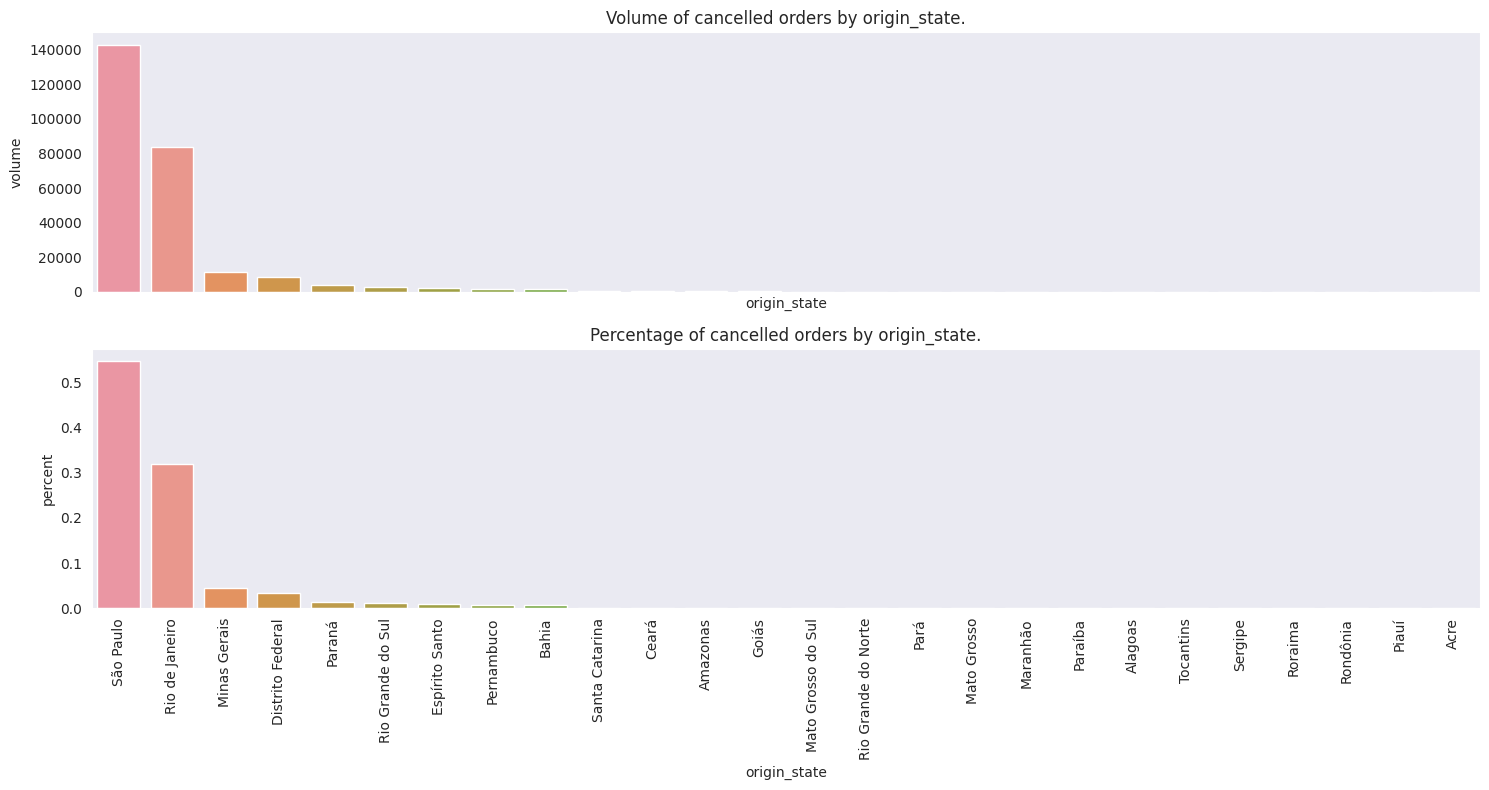

In [20]:
visuals.double_barplot(df, 'origin_state')

We can verify that the 5 top origin cities are São Paulo, Rio de Janeiro, Belo Horizonte, Brasília and Curitiba. They represent almost 90% of the origins in this dataset.

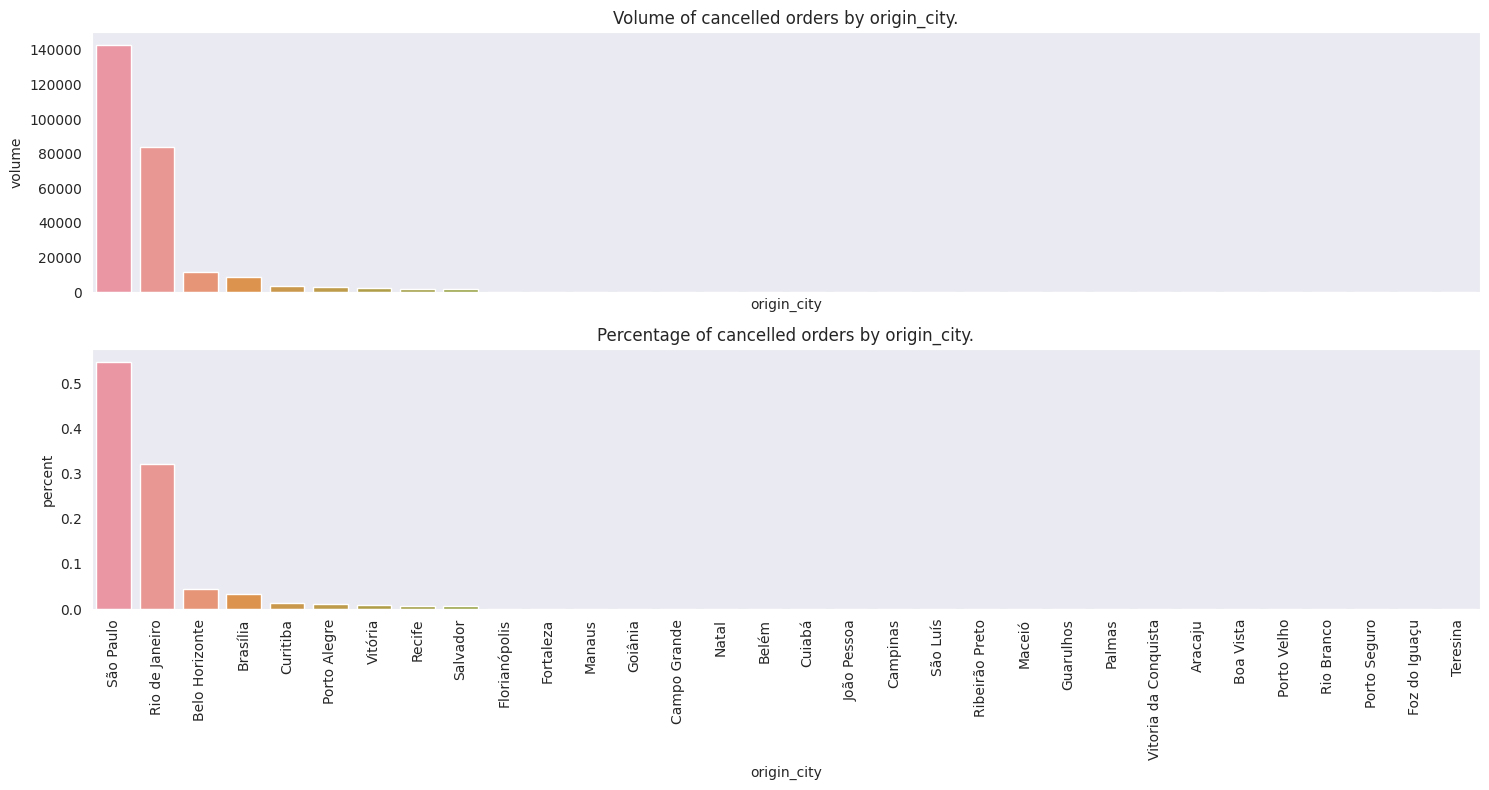

In [21]:
visuals.double_barplot(df, 'origin_city')

##### Destinations

More than 50% of the cancellations have national destination (Brazil).

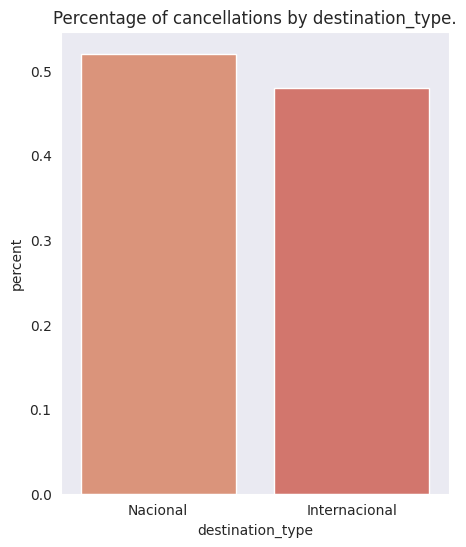

In [22]:
visuals.single_barplot(df, 'destination_type')

More thant 50% of the cancelled orders had Brazil as destination. The second destination with more cancellations is USA.

It would be interesting to understand the proportion of these cases on the overall purchase statistics, but we have no current access to this data.

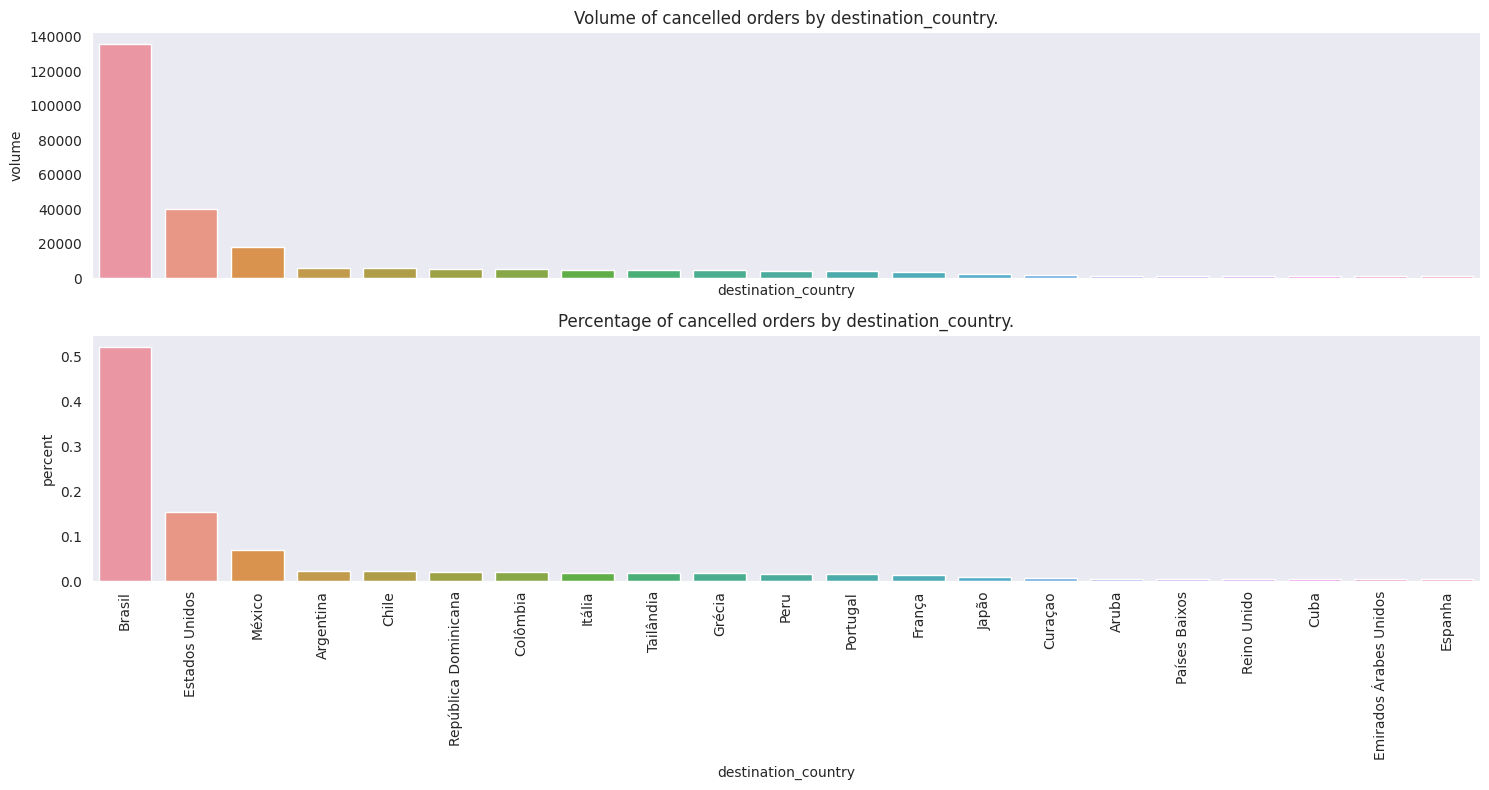

In [23]:
visuals.double_barplot(df, 'destination_country', 20)

We limited the plot to the top 35 destination states to keep the graph interpretable. It's possible to verify that in the top 10 destination state we have only two that are international: Flórida and Quintana Roo.

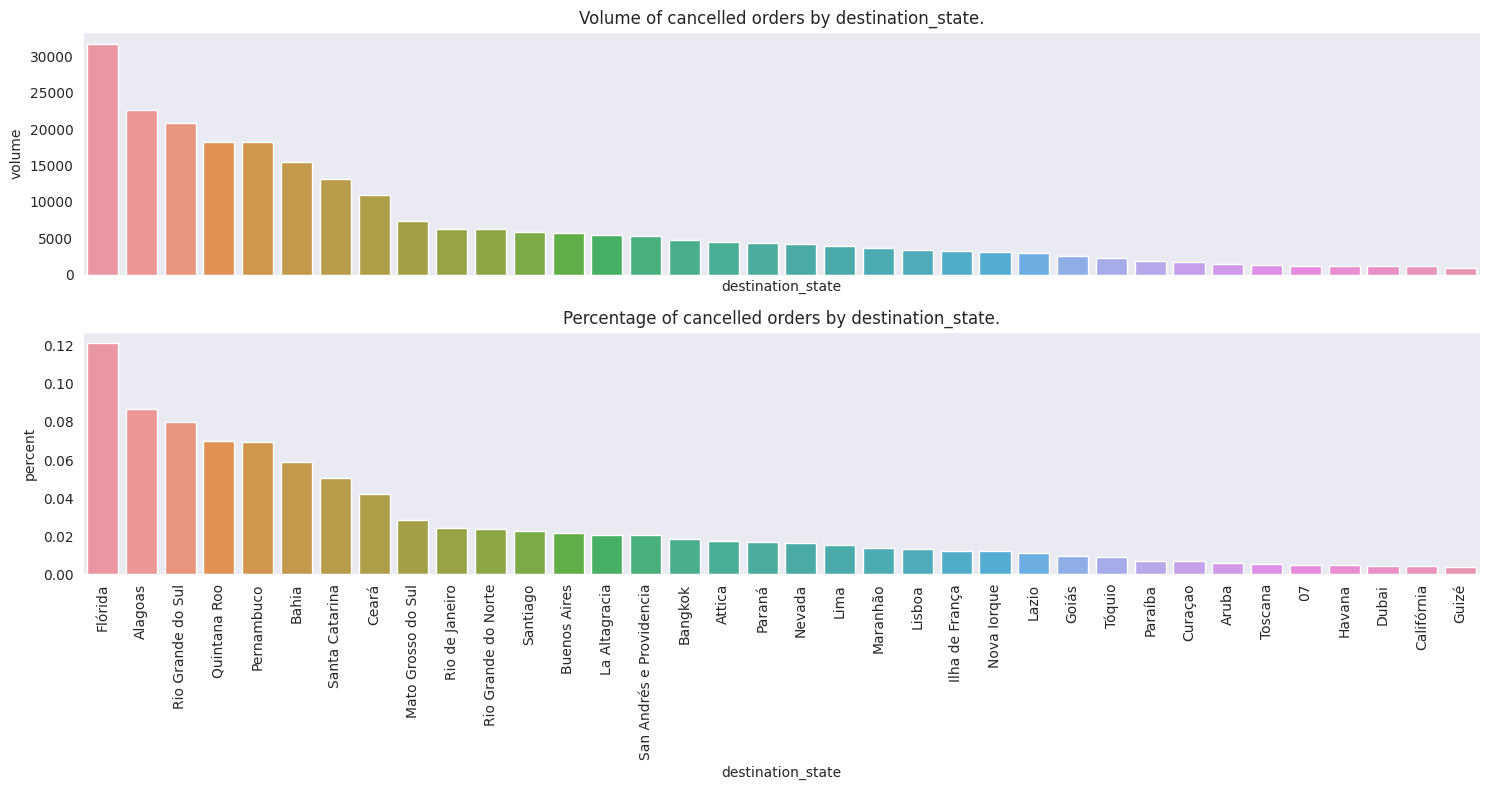

In [24]:
visuals.double_barplot(df, 'destination_state', 35)

Among the top cities within cancellations, we have the cities related to the international states mentioned before: Orlando (Florida) and Cancún (Quintana Roo). And a lot of Brazilian cities.

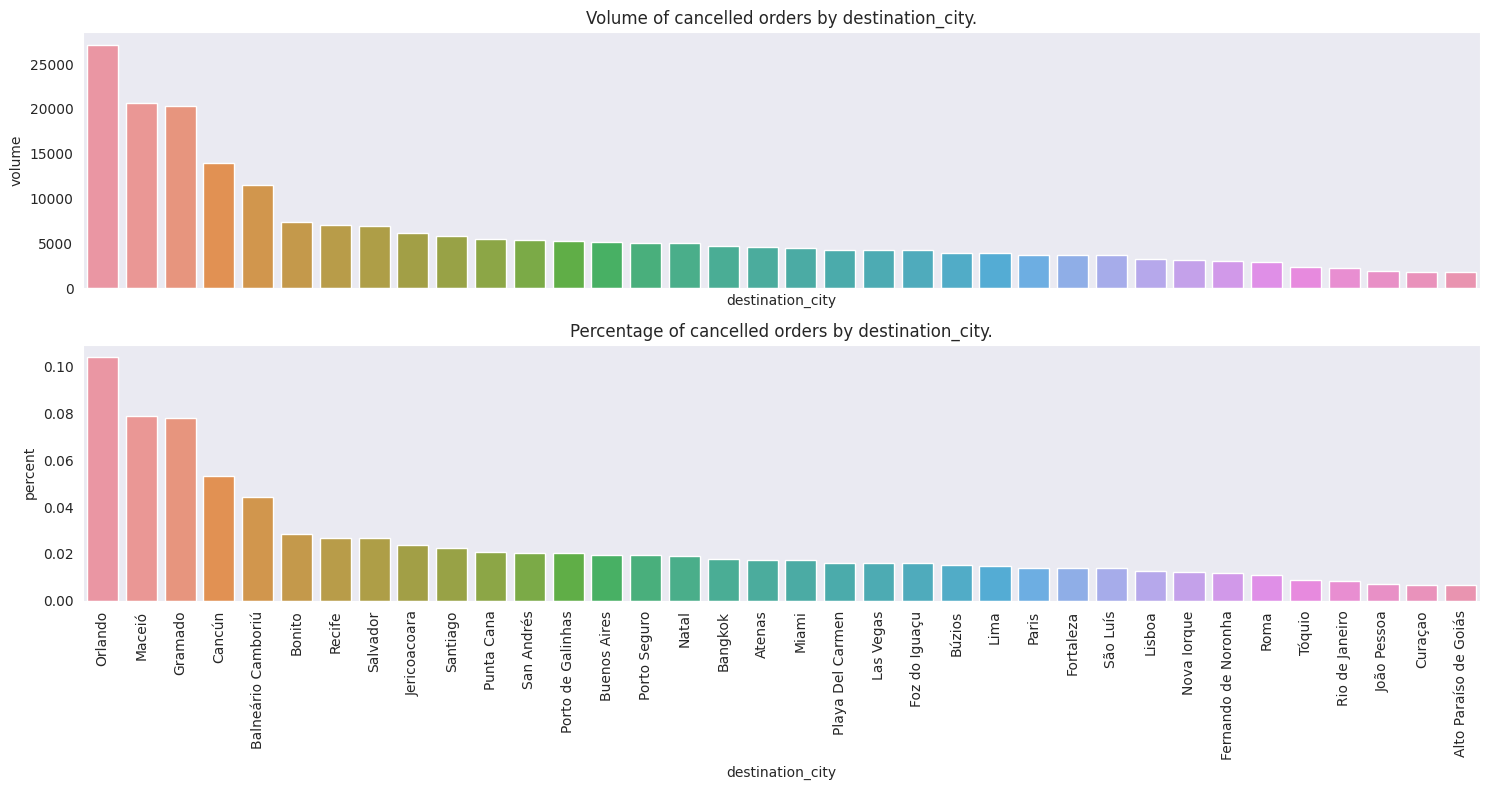

In [25]:
visuals.double_barplot(df, 'destination_city', 35)

##### Accomodations

We already selected the main categories of accommodation_type, the categories 'multiple' and 'duplo' have similar proportions.

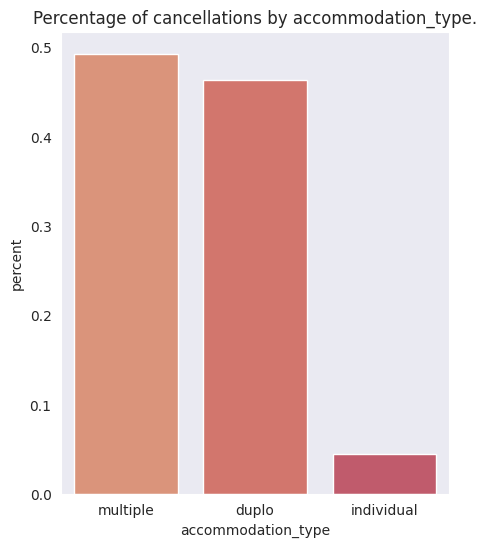

In [26]:
visuals.single_barplot(df, 'accommodation_type')

##### Filled Forms

In all cases the form was filled up, so we can discard this feature.

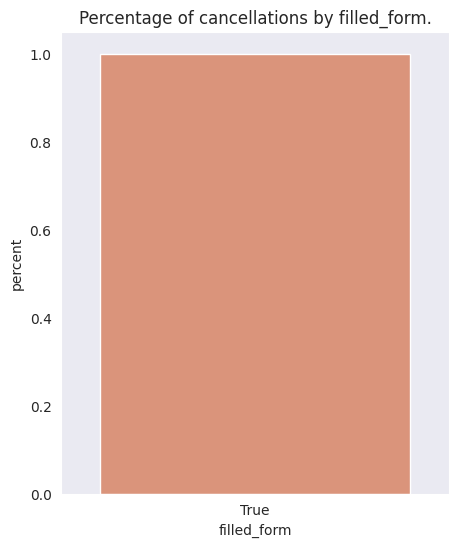

In [27]:
visuals.single_barplot(df, 'filled_form')

In [28]:
df = df.drop('filled_form', axis=1)

##### Operation status

More than a half of the cases had their operations started before the cancellation.

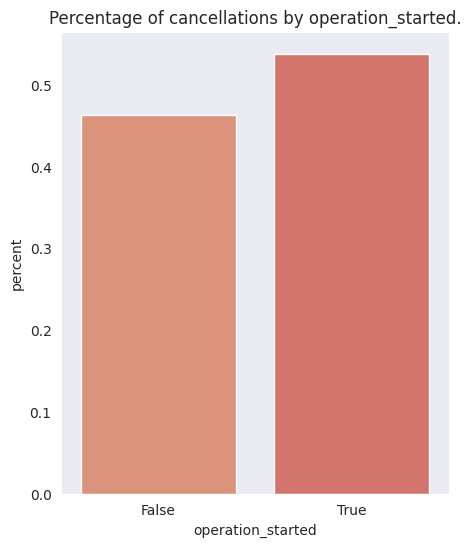

In [29]:
visuals.single_barplot(df, 'operation_started')

#### Datetime features

In [30]:
datetime_features = df.select_dtypes(include=['datetime']).columns
datetime_features

Index(['order_date', 'last_form_fill_date', 'first_valid_date',
       'last_valid_date', 'last_update_status_date'],
      dtype='object')

In [31]:
df_dates = utils.create_date_columns(df, ['first_valid_date', 'last_form_fill_date', 'last_update_status_date', 'last_valid_date', 'order_date'])

Let's compute the difference between the order_date and the last_update_status_date to verify the difference between the purchases and it's cancellations.

There is no time_to_cancel with more than 5% of share in the sample, the most representative is 0 days to cancel, but the data have a high cardinality.

We have a better visualization with a month granularity. There's also no pattern related to the time to cancel a order after the purchase.

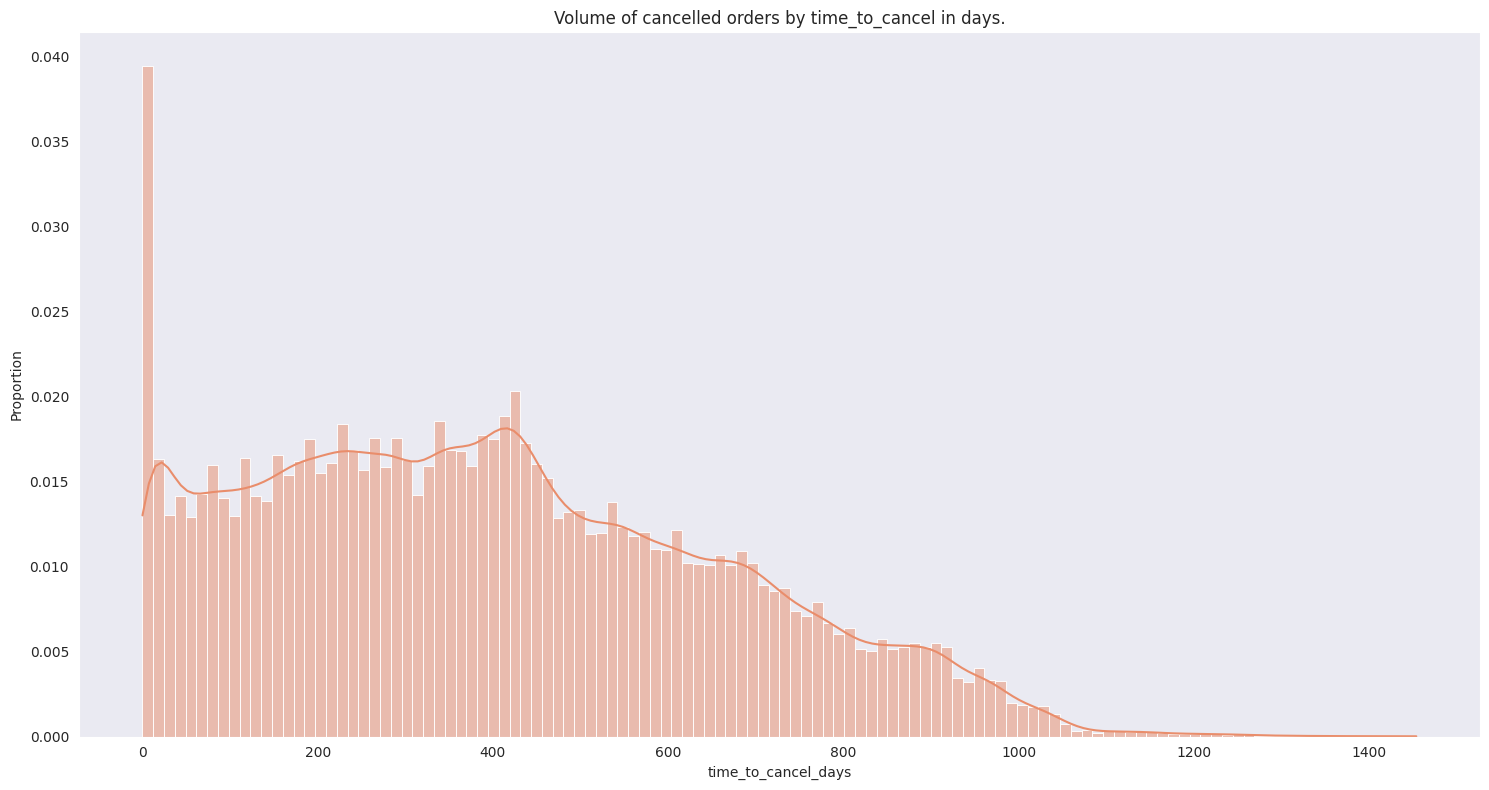

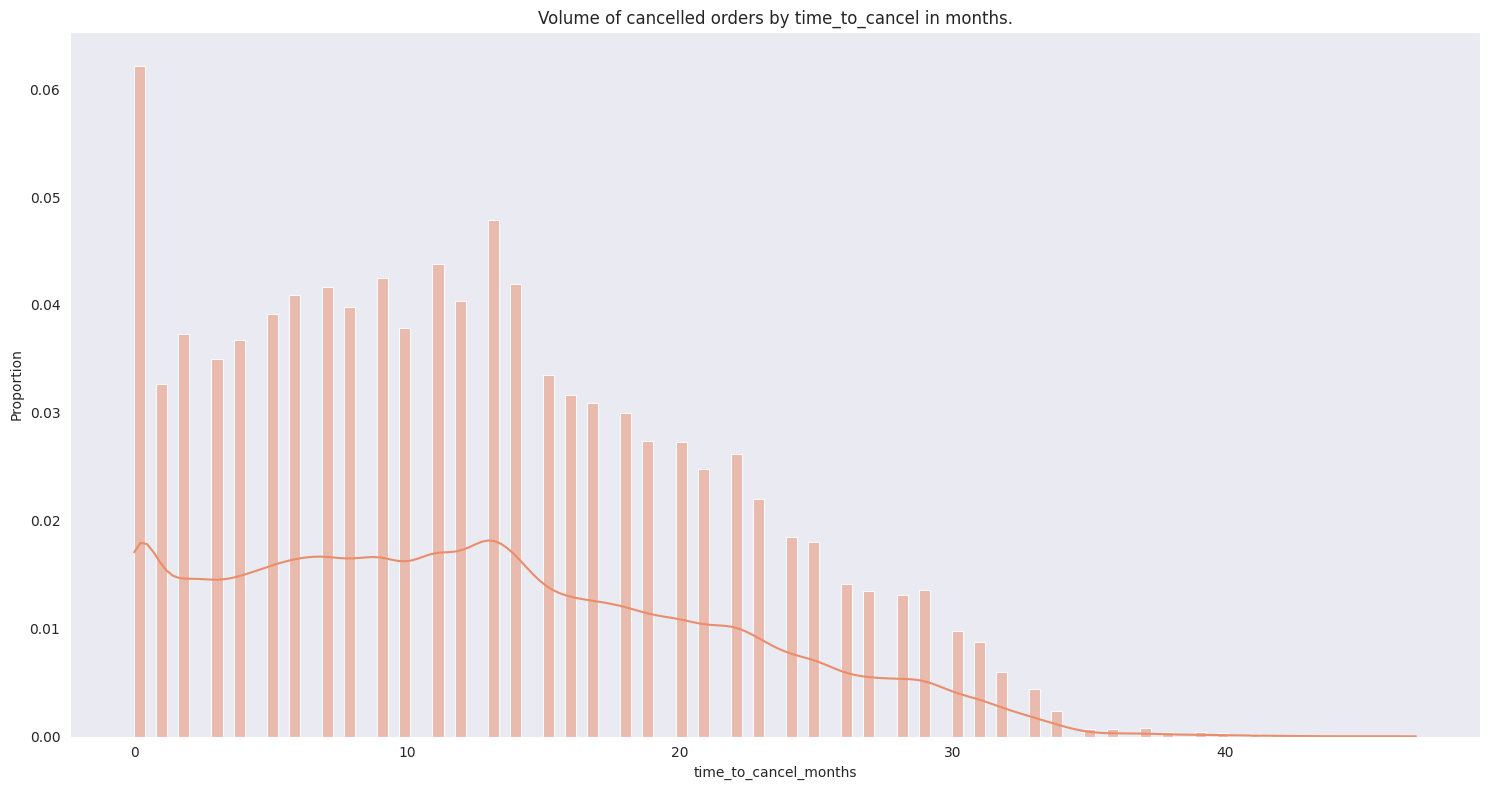

In [32]:
visuals.date_relationship(df, 'order_date', 'last_update_status_date', 'time_to_cancel')

Now let's verify if the last form fill date is close to the cancellation date (last_update_status_date). 

We'll consider negative time deltas as errors and these cases will be removed. Again we have a feature with high cardinality in the day granularity.

We have a better visualization with a month granularity. Apparently, the cancellation process usually occurs after a few months of the form being completed.

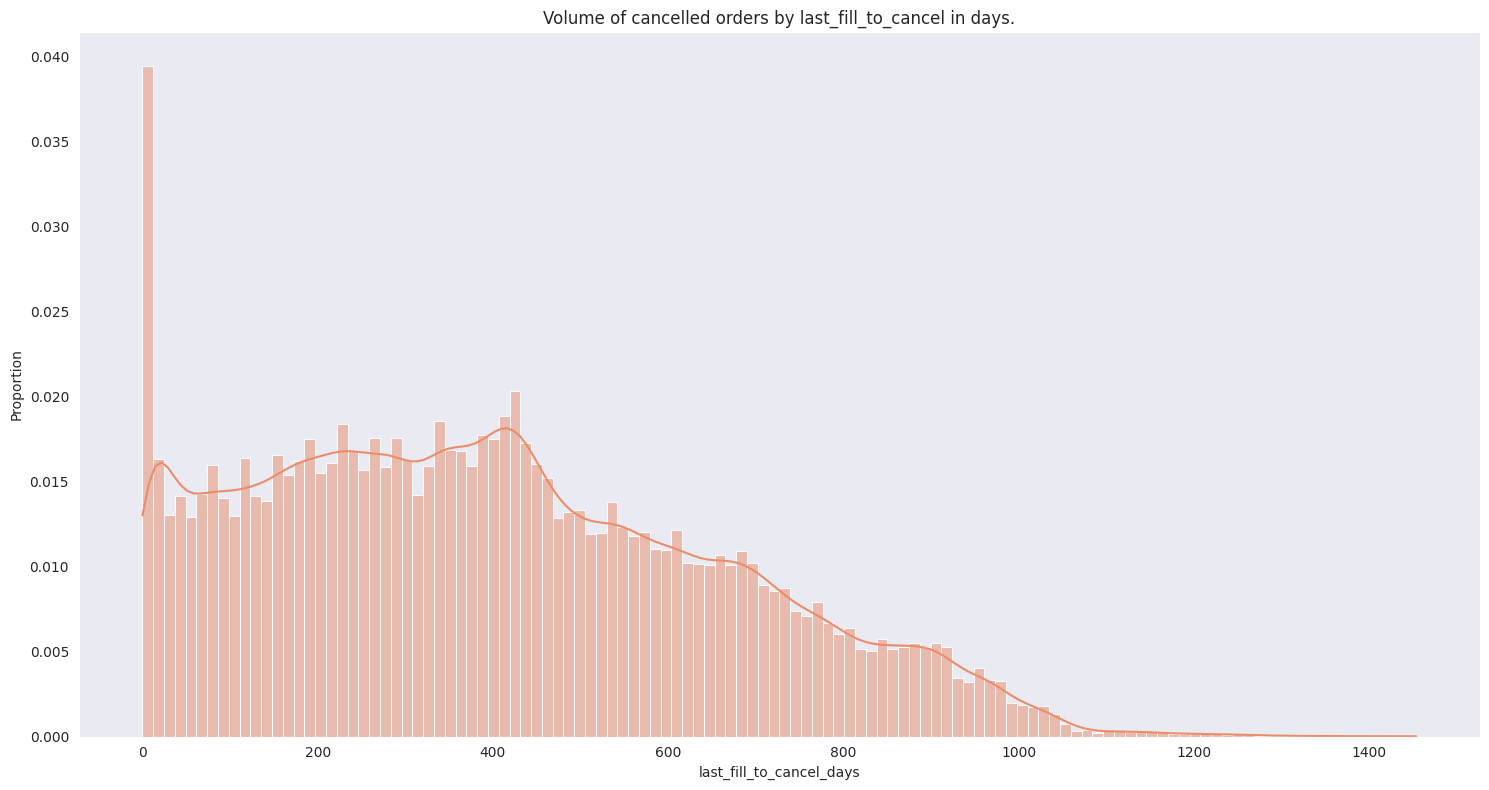

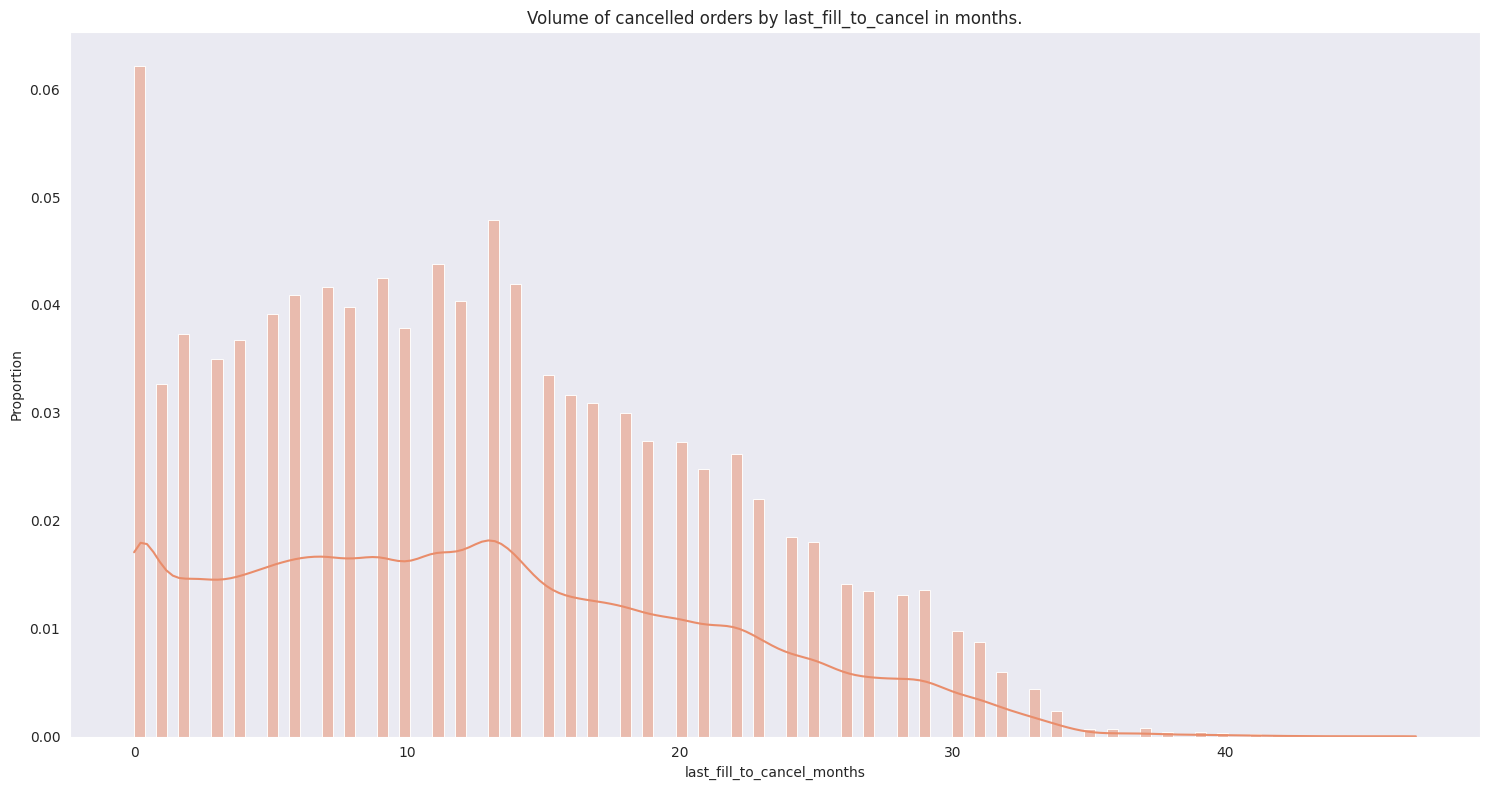

In [33]:
visuals.date_relationship(df, 'order_date', 'last_update_status_date', 'last_fill_to_cancel')

#### Numerical

In [34]:
numerical_features = df.select_dtypes(include=['int64']).columns
numerical_features

Index(['qty_people', 'qty_dailies', 'qty_status_changes'], dtype='object')

The more people an order has, the less the number of dailies. Probably because it is harder to find a common date to travel. Similarly, the more people, the fewer status changes.

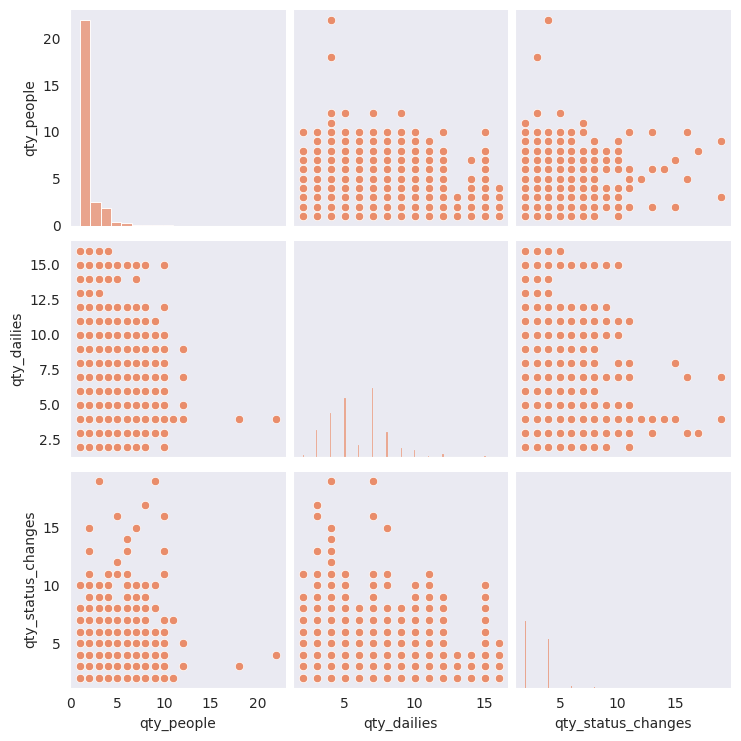

In [35]:
sns.pairplot(df[numerical_features]);

Most of the cancelled orders had 7 dailies e the majority (around 80%) of cases had 7 or less dailies.

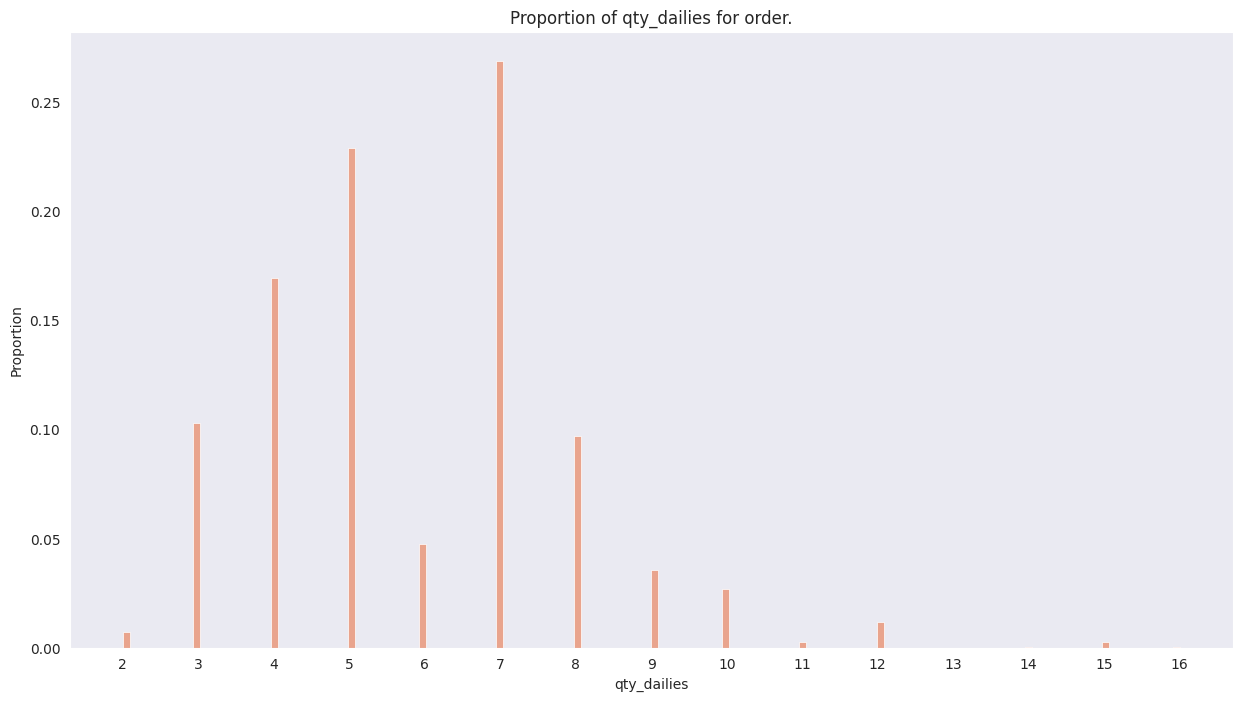

In [36]:
visuals.single_histplot(df, 'qty_dailies')

In [54]:
(df.groupby('qty_dailies').count()['order_date'].sort_index()/df.qty_dailies.count()).cumsum()

qty_dailies
2     0.007292
3     0.109932
4     0.278943
5     0.507704
6     0.555303
7     0.823781
8     0.920534
9     0.956263
10    0.983031
11    0.985558
12    0.997198
13    0.997217
14    0.997477
15    0.999897
16    1.000000
Name: order_date, dtype: float64

Almost 60% of the cases had 2 persons and around 20% had just one traveler.

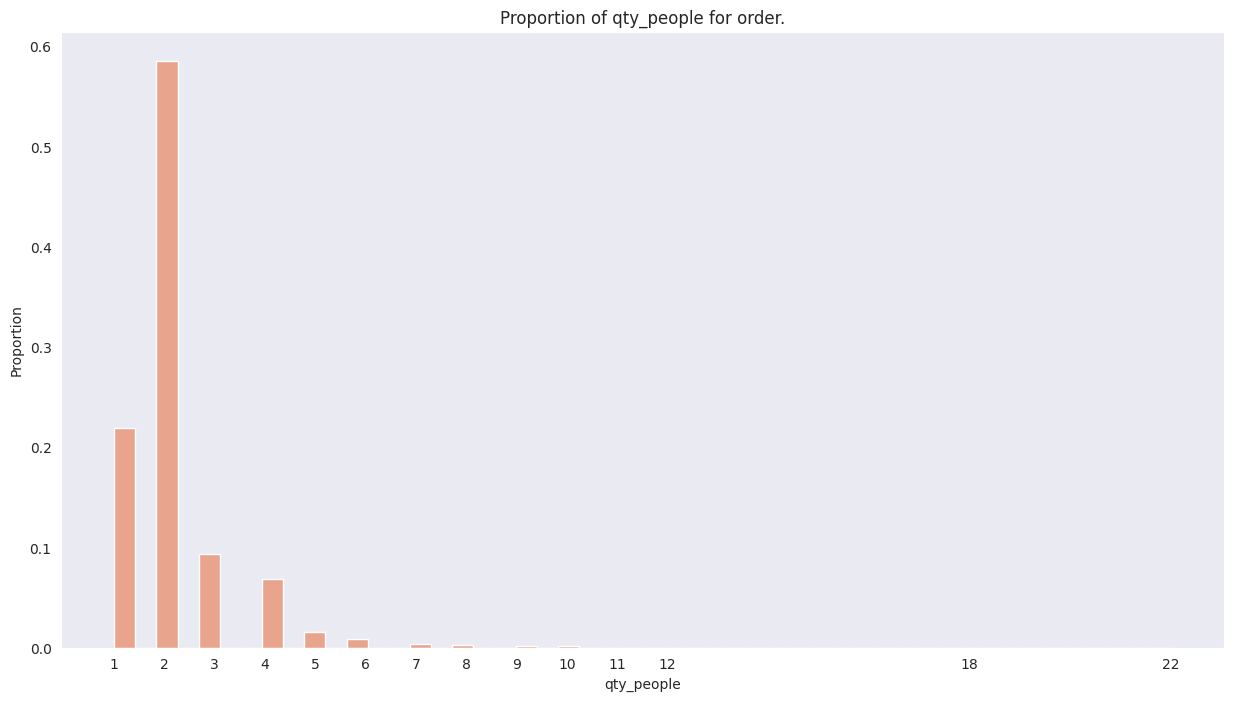

In [62]:
visuals.single_histplot(df, 'qty_people', bins=50)

Around 25% of the cases had just 2 status changes, in this cases maybe the order was cancelled right away. Less than 25% os the cases had more than 3 status changes.

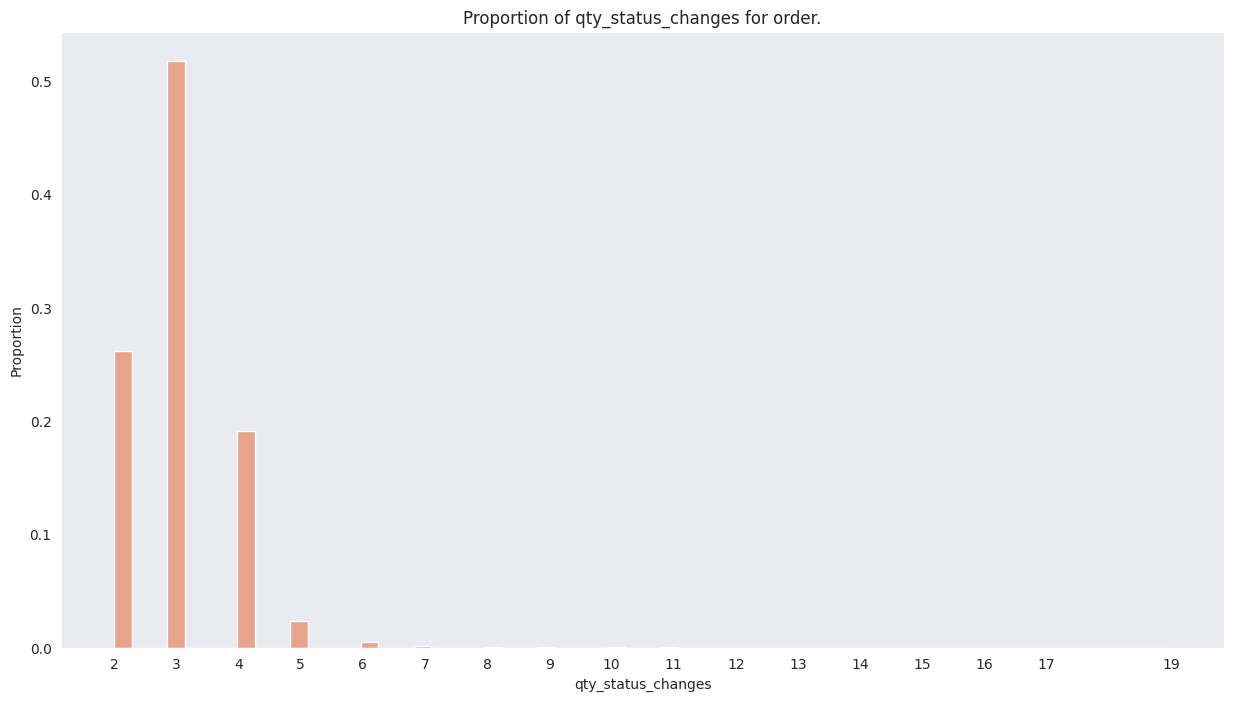

In [72]:
visuals.single_histplot(df, 'qty_status_changes', bins=60)

Proportionally, most of the orders had their operation started before the cancellation for cases from 3 status changes or more. Being the case of 4 status changes, the one with the biggest difference.

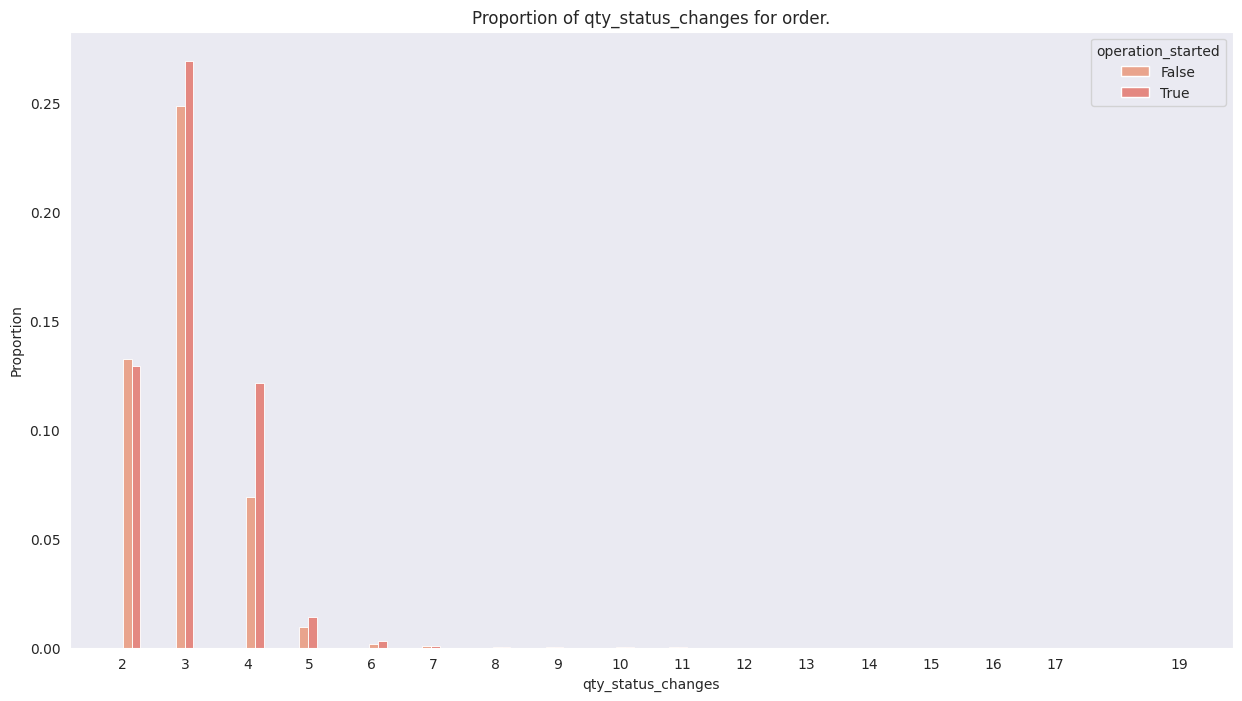

In [79]:
visuals.single_histplot(df, 'qty_status_changes', bins=60, hue='operation_started', multiple='dodge')

Let's now perform an ANOVA Test to evaluate the correlation between the categorical and quantitative features: